In [11]:
import sys

# sys.path.append("/scratch/group/csce435-f24/python-3.10.4/lib/python3.10/site-packages")
sys.path.append("C:/Users/jaesu/AppData/Local/Programs/Python/Python312/Lib/site-packages")
# sys.path.append("/scratch/group/csce435-f24/thicket")
from glob import glob

import matplotlib.pyplot as plt 
import pandas as pd

import thicket as th

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [13]:
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

algorithms = ["merge", "bitonic", "sample"]
input_sizes = [262144, 1048576, 4194304, 16777216, 67108864]
input_types = ["sorted", "random", "reverse", "perturbed"]
num_procs = [2, 8, 32, 128, 512]


# gather all the specific files from each algorithm's cali directory
cali_files = []
tk_dict = {}
for alg in algorithms:
    cali_files = []
    for n in num_procs:
        for size in input_sizes:
            for type in input_types:
                filename = f"p{n}-a{size}-{type}-{alg}.cali"
                directory = f"cali_files/{alg}_cali"
                filepath = os.path.join(directory, filename)
                if os.path.exists(filepath):
                    cali_files.append(filepath)
                else:
                    print(f"{filepath} is missing")
    # Create Thicket object for each algorithm
    tk = th.Thicket.from_caliperreader(cali_files)
    tk_dict[alg] = tk

(2/2) Creating Thicket: 100%|██████████| 99/99 [00:01<00:00, 78.46it/s] 


In [15]:
for alg, tk in tk_dict.items():
    tk.metadata_column_to_perfdata("algorithm")
    tk.metadata_column_to_perfdata("input_size")
    tk.metadata_column_to_perfdata("input_type")
    tk.metadata_column_to_perfdata("num_procs")

    tk.dataframe = tk.dataframe.reset_index().set_index(["node", "algorithm", "input_size", "input_type", "num_procs"]).sort_index()

    tk.dataframe.head()

In [17]:

proc_size_mapping = {
    262144: 2,
    1048576: 8,
    4194304: 32,
    16777216: 128,
    67108864: 512
}

execution_times = []

for alg, tk in tk_dict.items():
    for node in tk.graph.traverse():
        if node.frame["name"] != 'main':
            continue
        for size in input_sizes:
            n = proc_size_mapping[size]

            # Get the execution time for the main function
            execution_time = None
            df = tk.dataframe.loc[node, "Avg time/rank"]

            # filer df by num_procs and input_size
            df = df.loc[(df.index.get_level_values("num_procs") == n) & (df.index.get_level_values("input_size") == size)]
            print(df)


algorithm  input_size  input_type  num_procs
merge      262144      perturbed   2            0.098351
                       random      2            0.073564
                       reverse     2            0.042981
                       sorted      2            0.039056
Name: Avg time/rank, dtype: float64
algorithm  input_size  input_type  num_procs
merge      1048576     perturbed   8            0.118727
                       random      8            0.088810
                       reverse     8            0.055930
                       sorted      8            0.062220
Name: Avg time/rank, dtype: float64
algorithm  input_size  input_type  num_procs
merge      4194304     perturbed   32           0.157183
                       random      32           0.131137
                       reverse     32           0.099944
                       sorted      32           0.104260
Name: Avg time/rank, dtype: float64
algorithm  input_size  input_type  num_procs
merge      16777216    pertu

for sorted type input
[0.039056, 0.06222, 0.10426, 0.268419, 0.586235]
[0.3312, 0.550217, 1.541247, 1.729934, 2.10298]
[0.489032, 0.579542, 1.664444, 2.207199, 2.92936]


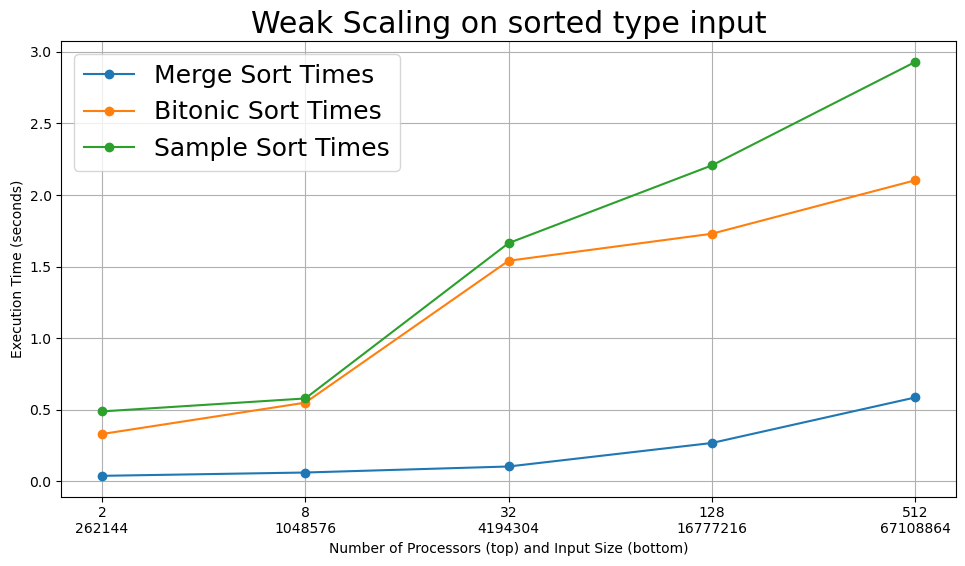

for random type input
[0.073564, 0.08881, 0.131137, 0.253547, 0.717135]
[0.385093, 0.609224, 1.665734, 2.066779, 3.310771]
[0.451185, 0.898166, 1.935481, 2.481123, 4.076721]


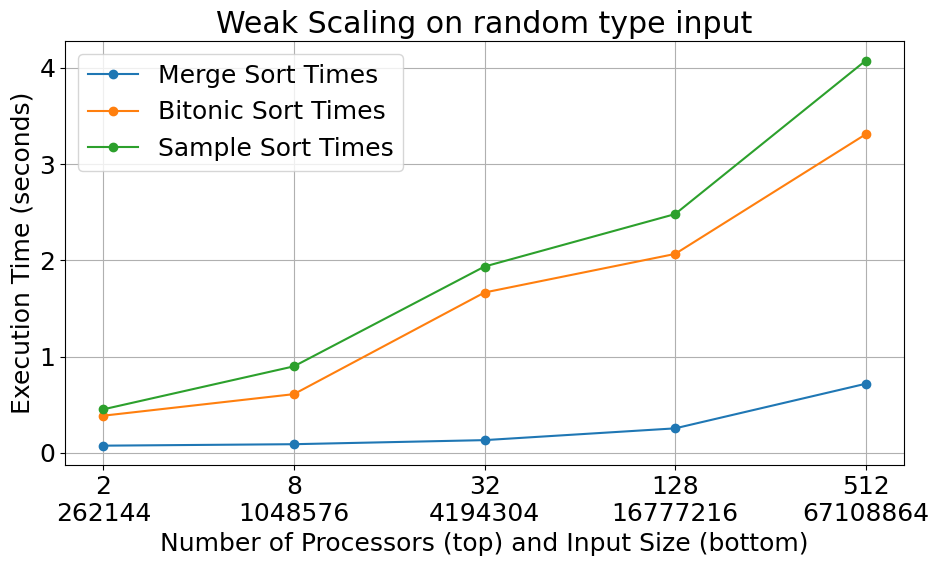

for reverse type input
[0.042981, 0.05593, 0.099944, 0.219568, 0.460395]
[0.314576, 0.498565, 1.598301, 1.710468, 2.110121]
[0.420225, 0.754516, 1.651063, 1.915674, 2.905204]


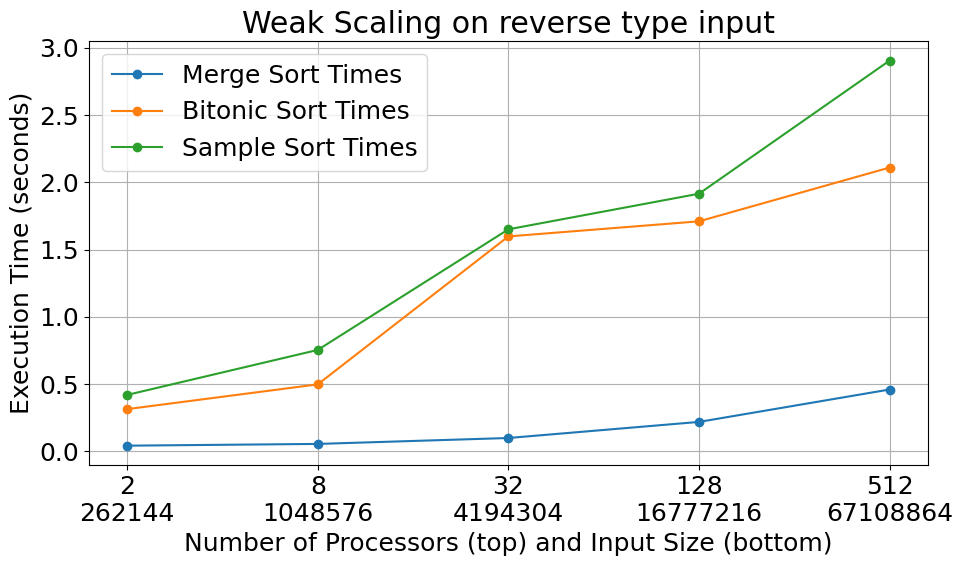

for perturbed type input
[0.098351, 0.118727, 0.157183, 0.272932, 0.502228]
[0.388011, 0.533297, 1.622337, 2.847994, 2.143981]
[0.451153, 0.83978, 1.932962, 3.482434, 7.865938]


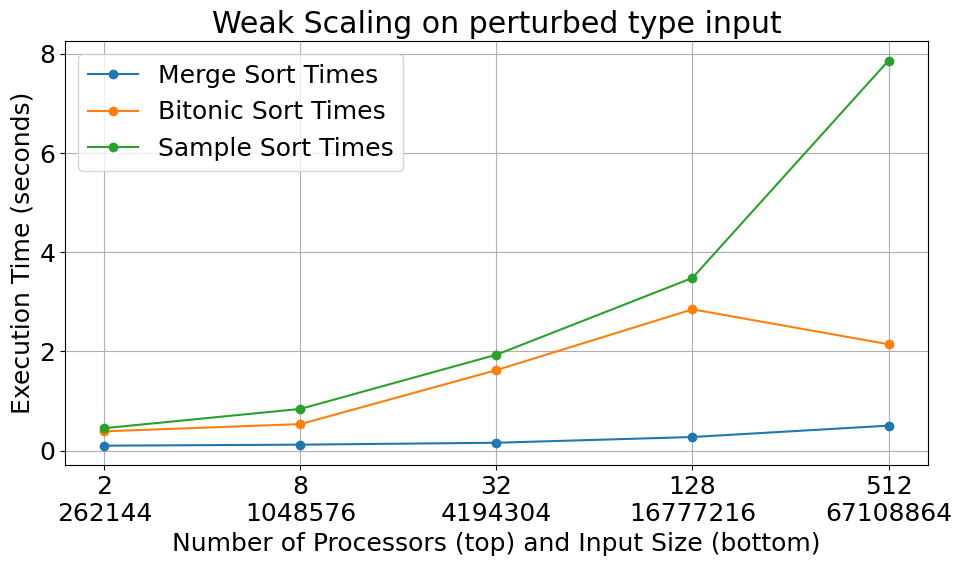

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Your existing mapping and input sizes
proc_size_mapping = {
    262144: 2,
    1048576: 8,
    4194304: 32,
    16777216: 128,
    67108864: 512
}

input_sizes = [262144, 1048576, 4194304, 16777216, 67108864]

# Initialize an empty list to collect data
data = []

merge_times = []
bitonic_times = []
sample_times = []

for type in input_types:
    # Traverse your graph and collect execution times
    for alg, tk in tk_dict.items():
        for node in tk.graph.traverse():
            if node.frame["name"] != 'main':
                continue
            for size in input_sizes:
                n = proc_size_mapping[size]

                # Get the execution time for the main function
                df = tk.dataframe.loc[node, "Avg time/rank"]
                # Filter df by num_procs and input_size
                df_filtered = df.loc[
                    (df.index.get_level_values("num_procs") == n) &
                    (df.index.get_level_values("input_size") == size) &
                    (df.index.get_level_values("input_type") == type)
                ]

                execution_times = df_filtered.values[0]
                if alg == "merge":
                    merge_times.append(execution_times)
                elif alg == "bitonic":
                    bitonic_times.append(execution_times)
                else:
                    sample_times.append(execution_times)
    merge_times = merge_times[-5:]
    bitonic_times = bitonic_times[-5:]
    sample_times = sample_times[-5:]

    print('for ' + type + ' type input')
    print(merge_times)
    print(bitonic_times)
    print(sample_times)

    # plot the data
    x_labels = [f"{proc}\n{size}" for proc, size in zip(num_procs, input_sizes)]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(x_labels, merge_times, marker='o', label='Merge Sort Times')
    plt.plot(x_labels, bitonic_times, marker='o', label='Bitonic Sort Times')
    plt.plot(x_labels, sample_times, marker='o', label='Sample Sort Times')
    plt.rcParams.update({"font.size": 18})

    # Labeling
    plt.xlabel('Number of Processors (top) and Input Size (bottom)')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Weak Scaling on ' + type + ' type input')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # save
    plt.savefig('weak_scaling_' + type + '.png')

    plt.show()
